# COVID-19 Predictions
CS 3281 Final Project by Canwen Jiao, April 2020

In [196]:
""" DATA PREPROCESSING """

# The data comes from: @https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
# It's in CSV format where each row shows the progression of cases for 
# a country or a state/province of a country

# Reference to some of the LSTM code:
# @https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

import csv
import numpy as np

n_samples = 109  # how many training samples we wish to obtain (<= 264)
n_steps_in = 20  # how many days of previous values we wish to account for
n_steps_out = 4  # how many days we wish to predict
# Note: n_steps_in + n_steps_out <= 87 (= 2020-04-27 - 2020-01-22)
norm = 9999  # normalization factor

def read_data(filename):
    Xtrain, ytrain = [], []
    Xtest, ytest = [], []
    with open(filename) as f:
        r = csv.reader(f)
        next(r, None)  # skip header
        for row in r:
            # Starting from the 5th column of each row (index 4) shows the
            # progression of cases starting 01/22/2020
            if row[1] == 'US':  # Exclude the United States, since it's used for testing
                Xtest=[int(x) for x in row[-n_steps_out - n_steps_in:-n_steps_out]]
                ytest=[int(x) for x in row[-n_steps_out:]]
            else:
                Xtrain.append([int(x) for x in row[-n_steps_out - n_steps_in:-n_steps_out]])
                ytrain.append([int(x) for x in row[-n_steps_out:]])
    return Xtrain[:n_samples], ytrain[:n_samples], Xtest, ytest

Xc, yc, Xct, yct = read_data('time_series_covid19_confirmed_global.csv')  # confirmed
Xd, yd, Xdt, ydt = read_data('time_series_covid19_deaths_global.csv')   # death

X = np.array([Xc, Xd])
Xt = np.array([Xct, Xdt])

n_features = X.shape[0]  # =2

# reshape the data so that it could be fed into the LSTM model
# also normalize the data so that the loss doesn't explode
X = X.reshape((n_samples, n_steps_in, n_features)) / norm
yc = np.array(yc).reshape((n_samples, n_steps_out, 1)) / norm
Xt = Xt.transpose().reshape((1, n_steps_in, n_features)) / norm
yct = np.array(yct) 

(n_samples, n_steps_in, n_steps_out, n_features, X.shape, yc.shape)

(109, 20, 4, 1, (109, 20, 1), (109, 4, 1))

In [191]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt

def plot(history):  # Plot training & validation accuracy values
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss'], loc='upper left')
    plt.show()

def pred(model):  # predict
    global ycp
    ycp = model.predict(Xt, verbose=1) * norm
    # print(ycp[0])
    plt.plot(ycp.reshape(n_steps_out))
    plt.plot(yct.reshape(n_steps_out))
    plt.title('Predicted cases VS actual cases')
    plt.ylabel('# of cases')
    plt.xlabel('Days')
    plt.legend(['predicted', 'actual'], loc='upper left')
    plt.show()

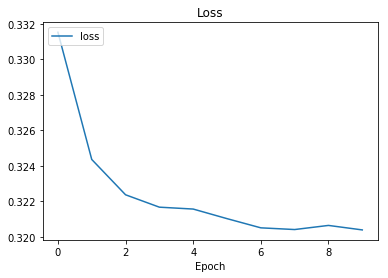

1/1 [==============================] - 0s 95ms/step


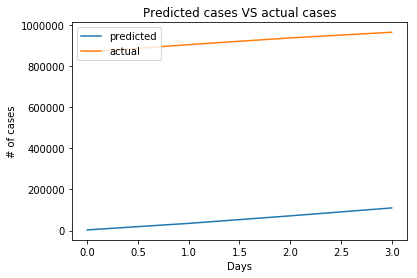

In [192]:
# univariate multi-step vector-output stacked lstm example
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')

# fit model
history = model.fit(X, yc, epochs=10, verbose=0)

plot(history)
pred(model)

In [195]:
ycp

array([[[  2907.1313],
        [ 34812.723 ],
        [ 71387.06  ],
        [109990.33  ]]], dtype=float32)

In [176]:
Xt = np.array([Xct, Xdt])
Xt.transpose().reshape((1, n_steps_in, n_features))# / norm


array([[[275367,   7090],
        [308650,   8408],
        [336802,   9619],
        [366317,  10783],
        [397121,  12794],
        [428654,  14704],
        [462780,  16544],
        [496535,  18595],
        [526396,  20471],
        [555313,  22029],
        [580619,  23538],
        [607670,  25843],
        [636350,  28338],
        [667592,  32930],
        [699706,  36787],
        [732197,  38664],
        [758809,  40661],
        [784326,  42094],
        [811865,  44444],
        [840351,  46622]]])

In [122]:
# univariate multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
# fit model
model.fit(X, y, epochs=50, verbose=1)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Epoch 1/50
5/5 [==============================] - 1s 202ms/step - loss: 65.6944
Epoch 2/50
5/5 [==============================] - 0s 2ms/step - loss: 65.2161
Epoch 3/50
5/5 [==============================] - 0s 2ms/step - loss: 64.7504
Epoch 4/50
5/5 [==============================] - 0s 2ms/step - loss: 64.3060
Epoch 5/50
5/5 [==============================] - 0s 2ms/step - loss: 63.8897
Epoch 6/50
5/5 [==============================] - 0s 2ms/step - loss: 63.4550
Epoch 7/50
5/5 [==============================] - 0s 1ms/step - loss: 62.9355
Epoch 8/50
5/5 [==============================] - 0s 997us/step - loss: 62.3305
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 61.6183
Epoch 10/50
5/5 [==============================] - 0s 1ms/step - loss: 60.7744
Epoch 11/50
5/5 [==============================] - 0s 997us/step - loss: 59.7690
Epoch 12/50
5/5 [==============================] - 0s 997us/step - loss: 58.5591
Epoch 13/50
5/5 [==============================] - 0s